Matthew Agard

Machine Learning, CPTR475

Final Project

12/13/18

# Understanding the Problem

https://www.kaggle.com/aishjun/nba-salaries-prediction-in-20172018-season

Additional files required:
- ``future_encoders.py``

## Predicting NBA Player Salaries

The "2017-18_NBA_salary.csv" dataset from Kaggle will be experimented upon in this notebook with the intent to unveil the correlation between an NBA player’s statistical output over the course of the 2017-18 NBA season and their salary for that same time period. 

It should be noted that this particular dataset isn’t comprised of traditional NBA stats such as points per game (PPG) or rebounds per game (RPG), but rather in advanced NBA stats such as win shares (WS) and player efficiency rating (PER). Using these advanced statistics is quickly becoming a growing trend in the NBA in deciding impactful team personnel outcomes.



## Problem Structure

This is a supervised regression problem because the dataset comes with the salary labels, which are continuous values that can be outputted as estimates by my models--which will be evaluated using the root mean squared error (RMSE) metric.


### Import Necessary Files & Modules

In [0]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", path)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

In [0]:
import pandas as pd
import os

from google.colab import drive
drive.mount('/content/drive/')

# Locate the stats CSV file in my computer's memory
NBA_PATH = os.path.join("nba-salaries-prediction-in-20172018-season")

# # Read the stats CSV file from my computer/Google Drive into a Pandas DataFrame
def load_nba_data(nba_path = NBA_PATH):
#     csv_path = os.path.join(nba_path, "2017-18_NBA_salary.csv")
#     return pd.read_csv(csv_path)
    return pd.read_csv('/content/drive/My Drive/Colab Notebooks/2017-18_NBA_salary.csv')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Getting & Exploring the Data

## Visualize Dataset Values

As is evidenced by the first code block in this section, I decided to preemptively remove the "Player" and "NBA_Country" features from my dataset.

I removed the Player feature because I feared experiencing overfitting in my training. There's a 1:1 ratio between player name and player salary, so my model could easily calculate the salary if it knows the player's name.

I removed the NBA_Country feature because regardless of where you're from, you have to live in the US over the course of a season and you get paid in US dollars, so I figured it wouldn't have any effect in either direction. 

In [0]:
# Retrieve NBA stats data from csv downloaded into local directory
nba_stats = load_nba_data()

# Drop undesired features from original dataset
nba_stats = nba_stats.drop(["Player", "NBA_Country"], axis = 1)
nba_stats.head()

,Salary,NBA_DraftNumber,Age,Tm,G,MP,PER,TS%,3PAr,FTr,...,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
0,815615,43,22,HOU,16,87,0.6,0.303,0.593,0.370,...,18.2,19.5,-0.4,0.1,-0.2,-0.121,-10.6,0.5,-10.1,-0.2
1,3477600,42,33,GSW,66,937,16.8,0.608,0.004,0.337,...,19.3,17.2,1.7,1.4,3.1,0.160,-0.6,1.3,0.8,0.7
2,12307692,19,36,SAC,59,1508,17.3,0.529,0.193,0.140,...,12.5,27.6,0.3,1.1,1.4,0.046,-0.6,-1.3,-1.9,0.0
3,3202217,13,22,CHI,24,656,14.6,0.499,0.346,0.301,...,9.7,29.5,-0.1,0.5,0.4,0.027,-0.7,-2.0,-2.6,-0.1
4,3057240,10,20,POR,62,979,8.2,0.487,0.387,0.146,...,15.6,15.5,-0.4,1.2,0.8,0.038,-3.7,0.9,-2.9,-0.2


In [0]:
nba_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 485 entries, 0 to 484
Data columns (total 26 columns):
Salary             485 non-null int64
NBA_DraftNumber    485 non-null int64
Age                485 non-null int64
Tm                 485 non-null object
G                  485 non-null int64
MP                 485 non-null int64
PER                485 non-null float64
TS%                483 non-null float64
3PAr               483 non-null float64
FTr                483 non-null float64
ORB%               485 non-null float64
DRB%               485 non-null float64
TRB%               485 non-null float64
AST%               485 non-null float64
STL%               485 non-null float64
BLK%               485 non-null float64
TOV%               483 non-null float64
USG%               485 non-null float64
OWS                485 non-null float64
DWS                485 non-null float64
WS                 485 non-null float64
WS/48              485 non-null float64
OBPM               485 non

In [0]:
nba_stats.describe()

,Salary,NBA_DraftNumber,Age,G,MP,PER,TS%,3PAr,FTr,ORB%,...,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
count,4.850000e+02,485.000000,485.000000,485.000000,485.000000,485.000000,483.000000,483.000000,483.000000,485.000000,...,483.000000,485.000000,485.000000,485.000000,485.000000,485.000000,485.000000,485.000000,485.000000,485.000000
mean,6.636507e+06,29.451546,26.263918,50.167010,1154.142268,13.260825,0.535387,0.337383,0.263404,4.873814,...,13.140373,18.897320,1.275464,1.176495,2.455258,0.079959,-1.270722,-0.489485,-1.760206,0.598763
std,7.392602e+06,21.125760,4.272297,24.874872,811.357419,8.769280,0.112352,0.226894,0.294578,4.582810,...,6.115290,5.940536,1.881444,1.034580,2.673670,0.162992,5.026275,2.389343,5.661447,1.245653
min,4.608000e+04,1.000000,19.000000,1.000000,1.000000,-41.100000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-2.300000,0.000000,-1.200000,-1.063000,-36.500000,-14.300000,-49.200000,-1.300000
25%,1.471382e+06,11.000000,23.000000,29.000000,381.000000,9.800000,0.505500,0.167000,0.155000,1.800000,...,9.900000,15.000000,0.000000,0.300000,0.300000,0.040000,-2.700000,-1.700000,-3.600000,-0.100000
50%,3.202217e+06,25.000000,26.000000,59.000000,1134.000000,13.200000,0.545000,0.346000,0.231000,3.200000,...,12.500000,17.900000,0.800000,1.000000,1.800000,0.083000,-1.100000,-0.400000,-1.300000,0.100000
75%,1.000000e+07,47.000000,29.000000,71.000000,1819.000000,16.500000,0.582500,0.481000,0.319500,7.000000,...,15.750000,22.200000,2.000000,1.800000,3.600000,0.123000,0.400000,1.000000,0.500000,0.900000
max,3.468255e+07,62.000000,41.000000,79.000000,2898.000000,134.100000,1.500000,1.000000,5.333000,35.900000,...,66.700000,45.100000,11.400000,5.600000,15.000000,2.713000,68.700000,6.800000,54.400000,8.600000


In [0]:
nba_stats['Tm'].value_counts()

TOT    55
DAL    18
MEM    17
UTA    17
PHI    16
ATL    16
IND    16
GSW    16
LAL    15
MIL    15
ORL    15
BOS    15
SAS    15
MIA    15
CHI    14
NYK    14
DET    14
NOP    14
POR    14
CHO    14
PHO    14
OKC    14
DEN    14
WAS    13
TOR    13
MIN    13
HOU    13
LAC    12
SAC    12
BRK    12
CLE    10
Name: Tm, dtype: int64

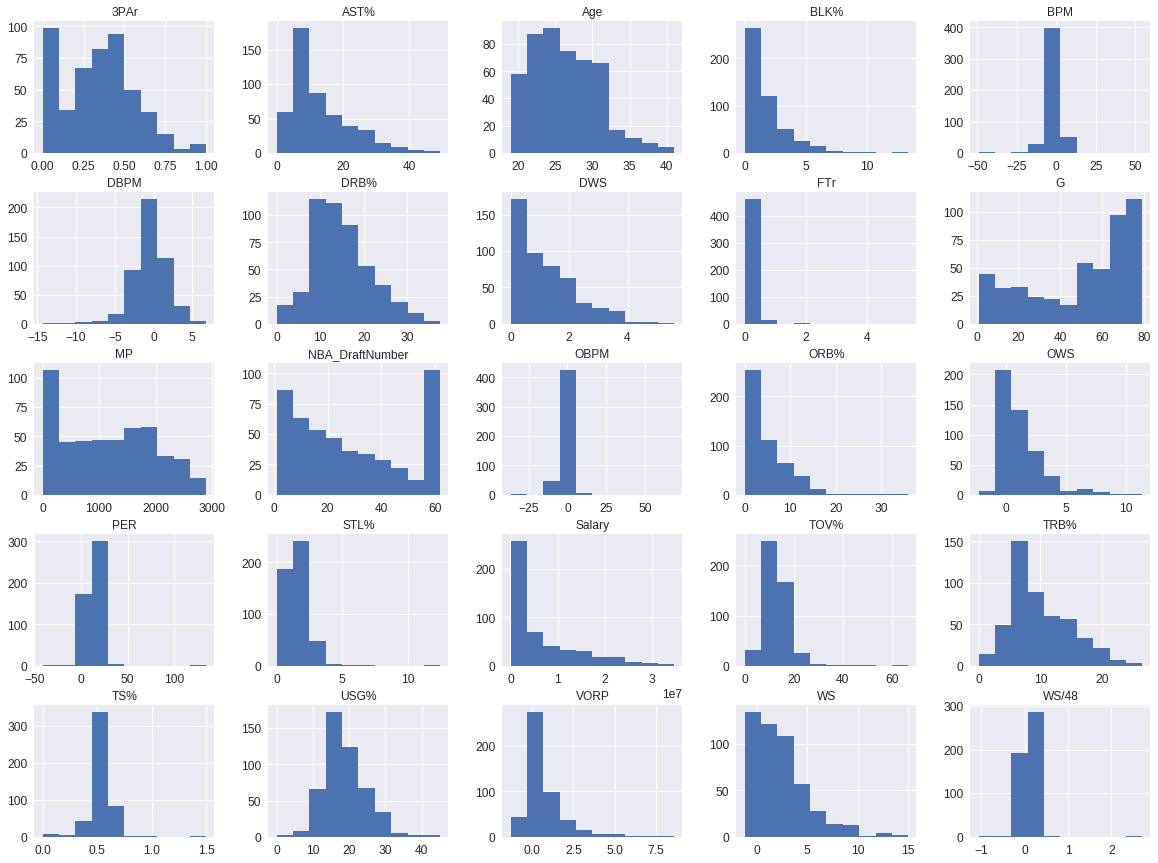

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

nba_stats.hist(bins=10, figsize = (20, 15))
plt.show()

## Identify Potentially Important Features

In [0]:
corr_matrix = nba_stats.corr()
corr_matrix["Salary"].sort_values(ascending=False)

Salary             1.000000
WS                 0.592499
VORP               0.573840
OWS                0.562933
MP                 0.506961
DWS                0.505500
Age                0.336454
BPM                0.310478
USG%               0.298756
G                  0.297700
PER                0.269823
AST%               0.266459
OBPM               0.265614
DRB%               0.195899
DBPM               0.177818
TS%                0.174759
WS/48              0.162398
TRB%               0.140563
BLK%               0.045225
STL%               0.035517
FTr                0.023494
ORB%               0.004221
TOV%              -0.043205
3PAr              -0.073502
NBA_DraftNumber   -0.381686
Name: Salary, dtype: float64

## Comments

This dataset is structured such that each tuple in the dataset is identified by a player name, followed by its corresponding statistcal features. 

All of the features are numerical with the exception of the "Tm" (team) feature. All  31 of its possible values will have to be encoded with a OneHotEncoder when it's time to clean the data.

Quite a few of the numerical features have value ranges that extend into the negative territory. Though I'm not exactly sure what effect that may have on my models' performances, I'm intrigued to see the result.

Lastly is the correlation matrix in relation to player salary displayed above. Naturally, WS (win shares) and VORP (value over replacement player)--two of the features most directly correlated to a player's contribution to winning games--are leaders in the impact made on salary decisions.



# Preparing the Data

## Check for Missing Feature Values

In [0]:
# Locate any tuples with missing feature values
missing_values = nba_stats[nba_stats.isnull().any(axis = 1)]
missing_values.head()

,Salary,NBA_DraftNumber,Age,Tm,G,MP,PER,TS%,3PAr,FTr,...,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
29,1579440,24,21,DEN,1,2,0.0,NaN,NaN,NaN,...,NaN,0.0,0.0,0.0,0.0,-0.016,-5.6,-0.9,-6.5,0.0
37,46080,62,27,IND,1,1,0.0,NaN,NaN,NaN,...,NaN,0.0,0.0,0.0,0.0,-0.001,-5.7,-0.1,-5.9,0.0


In [0]:
# Remove the tuples with missing feature values from the dataset
nba_stats = nba_stats.dropna(subset = ['TS%'])

I decided to remove the two player tuples in my dataset that had missing values because they're outliers. One of the players played only 1 minute the whole season and the other only played 2 minutes, so it can automatically be assumed they're making the veteran minimum--if they're still even in the NBA anymore. Their statistics, or lack thereof, wouldn't have contributed anything to the training.

## Prepare Train-Test Dataset Split

In [0]:
from sklearn.model_selection import train_test_split

# Perform a random split on the entire dataset; 80% training, 20% testing
train_set, test_set = train_test_split(nba_stats, test_size = 0.2, random_state = 42)

In [0]:
train_set.shape

(386, 26)

In [0]:
test_set.shape

(97, 26)

In [0]:
# Remove the output variable (salary) from the training set
# and store it in a separate variable
nba_stats = train_set.drop('Salary', axis = 1)
nba_salary = train_set['Salary'].copy()

## Separate Feature Types

In [0]:
# Extract and store all numerical features into a variable
nba_stats_num = nba_stats.drop(['Tm'], axis = 1)
nba_stats_num.head()

,NBA_DraftNumber,Age,G,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,...,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
413,48,22,29,159,16.6,0.575,0.000,0.513,10.8,13.0,...,5.9,13.7,0.4,0.2,0.6,0.180,-0.9,1.3,0.5,0.1
25,2,35,46,1151,14.3,0.657,0.000,0.503,12.2,26.9,...,20.5,10.6,1.9,0.8,2.6,0.110,-1.4,1.0,-0.4,0.5
222,15,22,77,2121,12.2,0.539,0.465,0.299,3.1,15.5,...,8.8,19.4,1.6,2.2,3.7,0.085,-0.6,-0.5,-1.1,0.5
397,62,25,66,1529,12.8,0.561,0.121,0.532,5.4,16.2,...,13.1,15.0,1.4,1.4,2.8,0.087,-2.2,1.2,-1.0,0.4
233,62,28,69,2180,10.9,0.518,0.574,0.211,1.5,12.6,...,9.8,18.0,0.4,1.6,1.9,0.043,-0.9,-0.2,-1.1,0.5


In [0]:
# Extract and store all categorical features into a variable
nba_stats_cat = nba_stats[['Tm']]
nba_stats_cat.head()

,Tm
413,OKC
25,PHO
222,WAS
397,CHI
233,CHI


## Future Encoders File
I was having trouble importing "future_encoders.py" into my notebook for encoding purposes, so I copied and pasted the necessary elements of the file here

In [0]:
from __future__ import division

import numbers
import warnings

import numpy as np
from scipy import sparse

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.externals import six
from sklearn.utils import check_array
from sklearn.utils.validation import check_is_fitted, FLOAT_DTYPES
from sklearn.preprocessing.label import LabelEncoder


BOUNDS_THRESHOLD = 1e-7


zip = six.moves.zip
map = six.moves.map
range = six.moves.range

__all__ = [
    'OneHotEncoder',
]


def _argmax(arr_or_spmatrix, axis=None):
    return arr_or_spmatrix.argmax(axis=axis)


def _handle_zeros_in_scale(scale, copy=True):
    ''' Makes sure that whenever scale is zero, we handle it correctly.

    This happens in most scalers when we have constant features.'''

    # if we are fitting on 1D arrays, scale might be a scalar
    if np.isscalar(scale):
        if scale == .0:
            scale = 1.
        return scale
    elif isinstance(scale, np.ndarray):
        if copy:
            # New array to avoid side-effects
            scale = scale.copy()
        scale[scale == 0.0] = 1.0
        return scale


def _transform_selected(X, transform, selected="all", copy=True):
    """Apply a transform function to portion of selected features

    Parameters
    ----------
    X : {array-like, sparse matrix}, shape [n_samples, n_features]
        Dense array or sparse matrix.

    transform : callable
        A callable transform(X) -> X_transformed

    copy : boolean, optional
        Copy X even if it could be avoided.

    selected: "all" or array of indices or mask
        Specify which features to apply the transform to.

    Returns
    -------
    X : array or sparse matrix, shape=(n_samples, n_features_new)
    """
    X = check_array(X, accept_sparse='csc', copy=copy, dtype=FLOAT_DTYPES)

    if isinstance(selected, six.string_types) and selected == "all":
        return transform(X)

    if len(selected) == 0:
        return X

    n_features = X.shape[1]
    ind = np.arange(n_features)
    sel = np.zeros(n_features, dtype=bool)
    sel[np.asarray(selected)] = True
    not_sel = np.logical_not(sel)
    n_selected = np.sum(sel)

    if n_selected == 0:
        # No features selected.
        return X
    elif n_selected == n_features:
        # All features selected.
        return transform(X)
    else:
        X_sel = transform(X[:, ind[sel]])
        X_not_sel = X[:, ind[not_sel]]

        if sparse.issparse(X_sel) or sparse.issparse(X_not_sel):
            return sparse.hstack((X_sel, X_not_sel))
        else:
            return np.hstack((X_sel, X_not_sel))


class _BaseEncoder(BaseEstimator, TransformerMixin):
    """
    Base class for encoders that includes the code to categorize and
    transform the input features.

    """

    def _fit(self, X, handle_unknown='error'):

        X_temp = check_array(X, dtype=None)
        if not hasattr(X, 'dtype') and np.issubdtype(X_temp.dtype, np.str_):
            X = check_array(X, dtype=np.object)
        else:
            X = X_temp

        n_samples, n_features = X.shape

        if self.categories != 'auto':
            for cats in self.categories:
                if not np.all(np.sort(cats) == np.array(cats)):
                    raise ValueError("Unsorted categories are not yet "
                                     "supported")
            if len(self.categories) != n_features:
                raise ValueError("Shape mismatch: if n_values is an array,"
                                 " it has to be of shape (n_features,).")

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                if handle_unknown == 'error':
                    valid_mask = np.in1d(Xi, self.categories[i])
                    if not np.all(valid_mask):
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(self.categories[i])

        self.categories_ = [le.classes_ for le in self._label_encoders_]

    def _transform(self, X, handle_unknown='error'):

        X_temp = check_array(X, dtype=None)
        if not hasattr(X, 'dtype') and np.issubdtype(X_temp.dtype, np.str_):
            X = check_array(X, dtype=np.object)
        else:
            X = X_temp

        _, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            Xi = X[:, i]
            valid_mask = np.in1d(Xi, self.categories_[i])

            if not np.all(valid_mask):
                if handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    Xi = Xi.copy()
                    Xi[~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(Xi)

        return X_int, X_mask


WARNING_MSG = (
    "The handling of integer data will change in the future. Currently, the "
    "categories are determined based on the range [0, max(values)], while "
    "in the future they will be determined based on the unique values.\n"
    "If you want the future behaviour, you can specify \"categories='auto'\"."
)


class OneHotEncoder(_BaseEncoder):
    def __init__(self, n_values=None, categorical_features=None,
                 categories=None, sparse=True, dtype=np.float64,
                 handle_unknown='error'):
        self._categories = categories
        if categories is None:
            self.categories = 'auto'
        else:
            self.categories = categories
        self.sparse = sparse
        self.dtype = dtype
        self.handle_unknown = handle_unknown

        if n_values is not None:
            pass
            # warnings.warn("Deprecated", DeprecationWarning)
        else:
            n_values = "auto"
        self._deprecated_n_values = n_values

        if categorical_features is not None:
            pass
            # warnings.warn("Deprecated", DeprecationWarning)
        else:
            categorical_features = "all"
        self._deprecated_categorical_features = categorical_features

    # Deprecated keywords

    @property
    def n_values(self):
        warnings.warn("The 'n_values' parameter is deprecated.",
                      DeprecationWarning)
        return self._deprecated_n_values

    @n_values.setter
    def n_values(self, value):
        warnings.warn("The 'n_values' parameter is deprecated.",
                      DeprecationWarning)
        self._deprecated_n_values = value

    @property
    def categorical_features(self):
        warnings.warn("The 'categorical_features' parameter is deprecated.",
                      DeprecationWarning)
        return self._deprecated_categorical_features

    @categorical_features.setter
    def categorical_features(self, value):
        warnings.warn("The 'categorical_features' parameter is deprecated.",
                      DeprecationWarning)
        self._deprecated_categorical_features = value

    # Deprecated attributes

    @property
    def active_features_(self):
        check_is_fitted(self, 'categories_')
        warnings.warn("The 'active_features_' attribute is deprecated.",
                      DeprecationWarning)
        return self._active_features_

    @property
    def feature_indices_(self):
        check_is_fitted(self, 'categories_')
        warnings.warn("The 'feature_indices_' attribute is deprecated.",
                      DeprecationWarning)
        return self._feature_indices_

    @property
    def n_values_(self):
        check_is_fitted(self, 'categories_')
        warnings.warn("The 'n_values_' attribute is deprecated.",
                      DeprecationWarning)
        return self._n_values_

    def _handle_deprecations(self, X):

        user_set_categories = False

        if self._categories is not None:
            self._legacy_mode = False
            user_set_categories = True

        elif self._deprecated_n_values != 'auto':
            msg = (
                "Passing 'n_values' is deprecated and will be removed in a "
                "future release. You can use the 'categories' keyword instead."
                " 'n_values=n' corresponds to 'n_values=[range(n)]'.")
            warnings.warn(msg, DeprecationWarning)

            # we internally translate this to the correct categories
            # and don't use legacy mode
            X = check_array(X, dtype=np.int)

            if isinstance(self._deprecated_n_values, numbers.Integral):
                n_features = X.shape[1]
                self.categories = [
                    list(range(self._deprecated_n_values))
                    for _ in range(n_features)]
                n_values = np.empty(n_features, dtype=np.int)
                n_values.fill(self._deprecated_n_values)
            else:
                try:
                    n_values = np.asarray(self._deprecated_n_values, dtype=int)
                    self.categories = [list(range(i))
                                       for i in self._deprecated_n_values]
                except (ValueError, TypeError):
                    raise TypeError(
                        "Wrong type for parameter `n_values`. Expected 'auto',"
                        " int or array of ints, got %r".format(type(X)))

            self._n_values_ = n_values
            n_values = np.hstack([[0], n_values])
            indices = np.cumsum(n_values)
            self._feature_indices_ = indices

            self._legacy_mode = False

        else:  # n_values = 'auto'
            if self.handle_unknown == 'ignore':
                # no change in behaviour, no need to raise deprecation warning
                self._legacy_mode = False
            else:

                # check if we have integer or categorical input
                try:
                    X = check_array(X, dtype=np.int)
                except ValueError:
                    self._legacy_mode = False
                else:
                    warnings.warn(WARNING_MSG, DeprecationWarning)
                    self._legacy_mode = True

        if (not isinstance(self._deprecated_categorical_features,
                           six.string_types)
                or (isinstance(self._deprecated_categorical_features,
                               six.string_types)
                    and self._deprecated_categorical_features != 'all')):
            if user_set_categories:
                raise ValueError(
                    "The 'categorical_features' keyword is deprecated, and "
                    "cannot be used together with specifying 'categories'.")
            warnings.warn("The 'categorical_features' keyword is deprecated.",
                          DeprecationWarning)
            self._legacy_mode = True

    def fit(self, X, y=None):
        """Fit OneHotEncoder to X.

        Parameters
        ----------
        X : array-like, shape [n_samples, n_feature]
            The data to determine the categories of each feature.

        Returns
        -------
        self
        """
        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        self._handle_deprecations(X)

        if self._legacy_mode:
            # TODO not with _transform_selected ??
            self._legacy_fit_transform(X)
            return self
        else:
            self._fit(X, handle_unknown=self.handle_unknown)
            return self

    def _legacy_fit_transform(self, X):
        """Assumes X contains only categorical features."""
        self_n_values = self._deprecated_n_values
        dtype = getattr(X, 'dtype', None)
        X = check_array(X, dtype=np.int)
        if np.any(X < 0):
            raise ValueError("X needs to contain only non-negative integers.")
        n_samples, n_features = X.shape
        if (isinstance(self_n_values, six.string_types) and
                self_n_values == 'auto'):
            n_values = np.max(X, axis=0) + 1
        elif isinstance(self_n_values, numbers.Integral):
            if (np.max(X, axis=0) >= self_n_values).any():
                raise ValueError("Feature out of bounds for n_values=%d"
                                 % self_n_values)
            n_values = np.empty(n_features, dtype=np.int)
            n_values.fill(self_n_values)
        else:
            try:
                n_values = np.asarray(self_n_values, dtype=int)
            except (ValueError, TypeError):
                raise TypeError("Wrong type for parameter `n_values`. Expected"
                                " 'auto', int or array of ints, got %r"
                                % type(X))
            if n_values.ndim < 1 or n_values.shape[0] != X.shape[1]:
                raise ValueError("Shape mismatch: if n_values is an array,"
                                 " it has to be of shape (n_features,).")

        self._n_values_ = n_values
        self.categories_ = [np.arange(n_val - 1, dtype=dtype)
                            for n_val in n_values]
        n_values = np.hstack([[0], n_values])
        indices = np.cumsum(n_values)
        self._feature_indices_ = indices

        column_indices = (X + indices[:-1]).ravel()
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)
        data = np.ones(n_samples * n_features)
        out = sparse.coo_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()

        if (isinstance(self_n_values, six.string_types) and
                self_n_values == 'auto'):
            mask = np.array(out.sum(axis=0)).ravel() != 0
            active_features = np.where(mask)[0]
            out = out[:, active_features]
            self._active_features_ = active_features

            self.categories_ = [
                np.unique(X[:, i]).astype(dtype) if dtype else np.unique(X[:, i])
                for i in range(n_features)]
            #import pdb; pdb.set_trace()

        return out if self.sparse else out.toarray()

    def fit_transform(self, X, y=None):
        """Fit OneHotEncoder to X, then transform X.

        Equivalent to self.fit(X).transform(X), but more convenient and more
        efficient. See fit for the parameters, transform for the return value.

        Parameters
        ----------
        X : array-like, shape [n_samples, n_feature]
            Input array of type int.
        """
        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        self._handle_deprecations(X)

        if self._legacy_mode:
            return _transform_selected(X, self._legacy_fit_transform,
                                       self._deprecated_categorical_features,
                                       copy=True)
        else:
            return self.fit(X).transform(X)

    def _legacy_transform(self, X):
        """Assumes X contains only categorical features."""
        self_n_values = self._deprecated_n_values
        X = check_array(X, dtype=np.int)
        if np.any(X < 0):
            raise ValueError("X needs to contain only non-negative integers.")
        n_samples, n_features = X.shape

        indices = self._feature_indices_
        if n_features != indices.shape[0] - 1:
            raise ValueError("X has different shape than during fitting."
                             " Expected %d, got %d."
                             % (indices.shape[0] - 1, n_features))

        # We use only those categorical features of X that are known using fit.
        # i.e lesser than n_values_ using mask.
        # This means, if self.handle_unknown is "ignore", the row_indices and
        # col_indices corresponding to the unknown categorical feature are
        # ignored.
        mask = (X < self._n_values_).ravel()
        if np.any(~mask):
            if self.handle_unknown not in ['error', 'ignore']:
                raise ValueError("handle_unknown should be either error or "
                                 "unknown got %s" % self.handle_unknown)
            if self.handle_unknown == 'error':
                raise ValueError("unknown categorical feature present %s "
                                 "during transform." % X.ravel()[~mask])

        column_indices = (X + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(np.sum(mask))
        out = sparse.coo_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if (isinstance(self_n_values, six.string_types) and
                self_n_values == 'auto'):
            out = out[:, self._active_features_]

        return out if self.sparse else out.toarray()

    def _transform_new(self, X):
        """New implementation assuming categorical input"""
        X_temp = check_array(X, dtype=None)
        if not hasattr(X, 'dtype') and np.issubdtype(X_temp.dtype, np.str_):
            X = check_array(X, dtype=np.object)
        else:
            X = X_temp

        n_samples, n_features = X.shape

        X_int, X_mask = self._transform(X, handle_unknown=self.handle_unknown)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        feature_indices = np.cumsum(n_values)

        indices = (X_int + feature_indices[:-1]).ravel()[mask]
        indptr = X_mask.sum(axis=1).cumsum()
        indptr = np.insert(indptr, 0, 0)
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csr_matrix((data, indices, indptr),
                                shape=(n_samples, feature_indices[-1]),
                                dtype=self.dtype)
        if not self.sparse:
            return out.toarray()
        else:
            return out

    def transform(self, X):
        """Transform X using one-hot encoding.

        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to encode.

        Returns
        -------
        X_out : sparse matrix if sparse=True else a 2-d array
            Transformed input.
        """
        if not self._legacy_mode:
            return self._transform_new(X)
        else:
            return _transform_selected(X, self._legacy_transform,
                                       self._deprecated_categorical_features,
                                       copy=True)

    def inverse_transform(self, X):
        """Convert back the data to the original representation.

        In case unknown categories are encountered (all zero's in the
        one-hot encoding), ``None`` is used to represent this category.

        Parameters
        ----------
        X : array-like or sparse matrix, shape [n_samples, n_encoded_features]
            The transformed data.

        Returns
        -------
        X_tr : array-like, shape [n_samples, n_features]
            Inverse transformed array.

        """
        # if self._legacy_mode:
        #     raise ValueError("only supported for categorical features")

        check_is_fitted(self, 'categories_')
        X = check_array(X, accept_sparse='csr')

        n_samples, _ = X.shape
        n_features = len(self.categories_)
        n_transformed_features = sum([len(cats) for cats in self.categories_])

        # validate shape of passed X
        msg = ("Shape of the passed X data is not correct. Expected {0} "
               "columns, got {1}.")
        if X.shape[1] != n_transformed_features:
            raise ValueError(msg.format(n_transformed_features, X.shape[1]))

        # create resulting array of appropriate dtype
        dt = np.find_common_type([cat.dtype for cat in self.categories_], [])
        X_tr = np.empty((n_samples, n_features), dtype=dt)

        j = 0
        found_unknown = {}

        for i in range(n_features):
            n_categories = len(self.categories_[i])
            sub = X[:, j:j + n_categories]

            # for sparse X argmax returns 2D matrix, ensure 1D array
            labels = np.asarray(_argmax(sub, axis=1)).flatten()
            X_tr[:, i] = self.categories_[i][labels]

            if self.handle_unknown == 'ignore':
                # ignored unknown categories: we have a row of all zero's
                unknown = np.asarray(sub.sum(axis=1) == 0).flatten()
                if unknown.any():
                    found_unknown[i] = unknown

            j += n_categories

        # if ignored are found: potentially need to upcast result to
        # insert None values
        if found_unknown:
            if X_tr.dtype != object:
                X_tr = X_tr.astype(object)

            for idx, mask in found_unknown.items():
                X_tr[mask, idx] = None

        return X_tr

## Categorical Encoding

In [0]:
# Perform OneHotEncoding on the Tm (team) categorical feature in the dataset.
# This will allow for the conversion of the string values to numbers
# for pipelining purposes
cat_encoder = OneHotEncoder()

nba_stats_cat_1hot = cat_encoder.fit_transform(nba_stats_cat)

In [0]:
print(nba_stats_cat_1hot)

  (0, 20)	1.0
  (1, 23)	1.0
  (2, 30)	1.0
  (3, 3)	1.0
  (4, 3)	1.0
  (5, 17)	1.0
  (6, 16)	1.0
  (7, 2)	1.0
  (8, 28)	1.0
  (9, 28)	1.0
  (10, 1)	1.0
  (11, 4)	1.0
  (12, 12)	1.0
  (13, 9)	1.0
  (14, 19)	1.0
  (15, 14)	1.0
  (16, 13)	1.0
  (17, 30)	1.0
  (18, 30)	1.0
  (19, 0)	1.0
  (20, 26)	1.0
  (21, 0)	1.0
  (22, 2)	1.0
  (23, 29)	1.0
  (24, 11)	1.0
  :	:
  (361, 21)	1.0
  (362, 21)	1.0
  (363, 0)	1.0
  (364, 13)	1.0
  (365, 0)	1.0
  (366, 7)	1.0
  (367, 14)	1.0
  (368, 4)	1.0
  (369, 7)	1.0
  (370, 23)	1.0
  (371, 29)	1.0
  (372, 28)	1.0
  (373, 10)	1.0
  (374, 5)	1.0
  (375, 9)	1.0
  (376, 30)	1.0
  (377, 17)	1.0
  (378, 25)	1.0
  (379, 10)	1.0
  (380, 25)	1.0
  (381, 18)	1.0
  (382, 2)	1.0
  (383, 28)	1.0
  (384, 28)	1.0
  (385, 20)	1.0


## Create Pipeline

In [0]:
from sklearn.base import BaseEstimator, TransformerMixin

# Create a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [0]:
# Create two separate pipelines for data cleaning, one for
# numerical features and the other for categorical features

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_attribs = list(nba_stats_num)
cat_attribs = list(nba_stats_cat)

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('cat_encoder', OneHotEncoder(sparse=False)),
    ])

In [0]:
# Join the numerical and categorical pipelines together
# to form a unified pipeline

from sklearn.pipeline import FeatureUnion
full_pipeline = FeatureUnion(transformer_list = [
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline)
])

In [0]:
#Generate and store a cleaned dataset for model training and evaluation
nba_stats_cleaned = full_pipeline.fit_transform(nba_stats)
nba_stats_cleaned.shape

(386, 55)

# Model Selection, Training, & Evaluation (Non-neural Net)

## Evaluate Performance on Validation Sets

In [0]:
# Import all necessary classes & methods to
# evaluate model training scores
import numpy as np
from sklearn.model_selection import cross_val_score

def display_scores(scores):
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

## Random Forest Regression

In [0]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor(random_state = 42)

# Cross-validate mean squared error scores
forest_scores = cross_val_score(forest_reg, nba_stats_cleaned, nba_salary,
                             scoring="neg_mean_squared_error", cv=10)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The de

In [0]:
# Derive and display RMSE metric from previously cross-validated scores
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Mean: 5515252.036841055
Standard deviation: 918847.3599394716


### Tuning hyperparameters

In [0]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=150),
        'max_features': randint(low=1, high=25),
    }

# Tune the hyperparameters to improve the random forest regressor
# model's performance.
forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', 
                                random_state=42)

# Fit the training set to the improved model
rnd_search.fit(nba_stats_cleaned, nba_salary)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f7760897d30>, 'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f775f202080>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=0)

In [0]:
# Identify optimal hyperparameter structure
rnd_search.best_params_

{'max_features': 22, 'n_estimators': 53}

## Test Set Performance

In [0]:
final_model = rnd_search.best_estimator_

In [0]:
X_test = test_set.drop("Salary", axis=1)
y_test = test_set["Salary"].copy()

In [0]:
# Clean the data set with the pipeline
X_test_cleaned = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_cleaned)

In [0]:
from sklearn.metrics import mean_squared_error

# Derive RMSE metric from test set evaluation
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [0]:
final_rmse

4174096.2823522706

# Model Selection, Training, & Evaluation (Neural Net)

## Create Validation Set

In [0]:
X_val = nba_stats_cleaned[:40]
partial_X_train = nba_stats_cleaned[40:]

y_val = nba_salary[:40]
partial_y_train = nba_salary[40:]

## Neural Net Construction

In [0]:
import keras
keras.__version__

import tensorflow as tf

Using TensorFlow backend.


In [0]:
from keras import models
from keras import layers

# Create model-building functions to instantiate multiple models
# with minimal code duplication

def build_one_layer_model(nodes, dataset): 
    model = models.Sequential()
    model.add(layers.Dense(nodes, activation='relu', input_shape=(dataset.shape[1],)))
    model.add(layers.Dense(1))
    
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    
    return model

def build_two_layer_model(nodes, dataset):
    model = models.Sequential()
    model.add(layers.Dense(nodes, activation='relu', input_shape=(dataset.shape[1],)))
    model.add(layers.Dense(nodes, activation='relu'))
    model.add(layers.Dense(1))
    
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    
    return model

def build_three_layer_model(nodes, dataset):
    model = models.Sequential()
    model.add(layers.Dense(nodes, activation='relu', input_shape=(dataset.shape[1],)))
    model.add(layers.Dense(nodes, activation='relu'))
    model.add(layers.Dense(nodes, activation='relu'))
    model.add(layers.Dense(1))
    
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    
    return model

In [0]:
# Number of nodes that can exist in a model's hidden layer
node_count = [32, 128]

## Neural Net Evaluation

In [0]:
# Evaluate the model's performance on the validation set
def train_and_validate_model(model):
    model.fit(partial_X_train,
            partial_y_train,
            epochs=8,
            batch_size=512,
            validation_data=(X_val, y_val))
  
    results = model.evaluate(X_val, y_val)
    return results

In [0]:
# Evaluate the model's performance on the test set
def test_model(model):
    model.fit(nba_stats_cleaned,
            nba_salary,
            epochs=8,
            batch_size=512)
    
    X_test_cleaned = full_pipeline.transform(X_test)
  
    results = model.evaluate(X_test_cleaned, y_test)
    return results

### One Hidden Layer

In [0]:
# Evaluate the model's performance on the validation set
# when 1 hidden layer is present
for i, num in enumerate(node_count):
  print("Iteration #", (i+1), ",", num, "nodes")
  
  model = build_one_layer_model(num, partial_X_train)
  results = train_and_validate_model(model)
  
  rmse = np.sqrt(results[0])
  print("RMSE:", round(rmse, 2), "\n\n\n")

Iteration # 1 , 32 nodes
Train on 346 samples, validate on 40 samples
Epoch 1/8
346/346 [==============================] - 0s 301us/step - loss: 99757544439808.0000 - mean_absolute_error: 6666723.0000 - val_loss: 124497705304064.0000 - val_mean_absolute_error: 7542516.0000
Epoch 2/8
346/346 [==============================] - 0s 20us/step - loss: 99757544439808.0000 - mean_absolute_error: 6666724.0000 - val_loss: 124497705304064.0000 - val_mean_absolute_error: 7542516.0000
Epoch 3/8
346/346 [==============================] - 0s 8us/step - loss: 99757544439808.0000 - mean_absolute_error: 6666724.0000 - val_loss: 124497705304064.0000 - val_mean_absolute_error: 7542516.0000
Epoch 4/8
346/346 [==============================] - 0s 7us/step - loss: 99757544439808.0000 - mean_absolute_error: 6666724.0000 - val_loss: 124497705304064.0000 - val_mean_absolute_error: 7542516.0000
Epoch 5/8
346/346 [==============================] - 0s 9us/step - loss: 99757544439808.0000 - mean_absolute_error: 666

### Two Hidden Layers

In [0]:
# Evaluate the model's performance on the validation set
# when 2 hidden layers are present
for i, num in enumerate(node_count):
  print("Iteration #", (i+1), ",", num, "nodes")
  
  model = build_two_layer_model(num, partial_X_train)
  results = train_and_validate_model(model)
  
  rmse = np.sqrt(results[0])
  print("RMSE:", round(rmse, 2), "\n\n\n")

Iteration # 1 , 32 nodes
Train on 346 samples, validate on 40 samples
Epoch 1/8
346/346 [==============================] - 0s 416us/step - loss: 99757561217024.0000 - mean_absolute_error: 6666724.0000 - val_loss: 124497705304064.0000 - val_mean_absolute_error: 7542516.0000
Epoch 2/8
346/346 [==============================] - 0s 9us/step - loss: 99757552828416.0000 - mean_absolute_error: 6666724.0000 - val_loss: 124497705304064.0000 - val_mean_absolute_error: 7542516.0000
Epoch 3/8
346/346 [==============================] - 0s 8us/step - loss: 99757561217024.0000 - mean_absolute_error: 6666724.0000 - val_loss: 124497705304064.0000 - val_mean_absolute_error: 7542516.0000
Epoch 4/8
346/346 [==============================] - 0s 10us/step - loss: 99757561217024.0000 - mean_absolute_error: 6666724.0000 - val_loss: 124497705304064.0000 - val_mean_absolute_error: 7542516.0000
Epoch 5/8
346/346 [==============================] - 0s 9us/step - loss: 99757552828416.0000 - mean_absolute_error: 666

### Three Hidden Layers

In [0]:
# Evaluate the model's performance on the validation set
# when 3 hidden layers are present
for i, num in enumerate(node_count):
  print("Iteration #", (i+1), ",", num, "nodes")
  
  model = build_three_layer_model(num, partial_X_train)
  results = train_and_validate_model(model)
  
  rmse = np.sqrt(results[0])
  print("RMSE:", round(rmse, 2), "\n\n\n")

Iteration # 1 , 32 nodes
Train on 346 samples, validate on 40 samples
Epoch 1/8
346/346 [==============================] - 0s 658us/step - loss: 99757561217024.0000 - mean_absolute_error: 6666724.0000 - val_loss: 124497705304064.0000 - val_mean_absolute_error: 7542516.0000
Epoch 2/8
346/346 [==============================] - 0s 22us/step - loss: 99757552828416.0000 - mean_absolute_error: 6666724.0000 - val_loss: 124497705304064.0000 - val_mean_absolute_error: 7542516.0000
Epoch 3/8
346/346 [==============================] - 0s 8us/step - loss: 99757552828416.0000 - mean_absolute_error: 6666723.0000 - val_loss: 124497705304064.0000 - val_mean_absolute_error: 7542516.0000
Epoch 4/8
346/346 [==============================] - 0s 8us/step - loss: 99757552828416.0000 - mean_absolute_error: 6666724.0000 - val_loss: 124497705304064.0000 - val_mean_absolute_error: 7542516.0000
Epoch 5/8
346/346 [==============================] - 0s 8us/step - loss: 99757544439808.0000 - mean_absolute_error: 666

## Test Set Performance

In [0]:
# Evaluate the performance of the model with the
# best hyperparamter structure on the test set
model = build_three_layer_model(128, nba_stats_cleaned)
results = test_model(model)
  
rmse = np.sqrt(results[0])
print("RMSE:", round(rmse, 2), "\n\n\n")

Epoch 1/8
386/386 [==============================] - 0s 749us/step - loss: 102321287593984.0000 - mean_absolute_error: 6757479.5000
Epoch 2/8
386/386 [==============================] - 0s 29us/step - loss: 102321287593984.0000 - mean_absolute_error: 6757479.0000
Epoch 3/8
386/386 [==============================] - 0s 24us/step - loss: 102321287593984.0000 - mean_absolute_error: 6757478.0000
Epoch 4/8
386/386 [==============================] - 0s 22us/step - loss: 102321279205376.0000 - mean_absolute_error: 6757477.5000
Epoch 5/8
386/386 [==============================] - 0s 20us/step - loss: 102321245650944.0000 - mean_absolute_error: 6757477.0000
Epoch 6/8
386/386 [==============================] - 0s 19us/step - loss: 102321228873728.0000 - mean_absolute_error: 6757475.5000
Epoch 7/8
386/386 [==============================] - 0s 21us/step - loss: 102321195319296.0000 - mean_absolute_error: 6757474.0000
Epoch 8/8
97/97 [==============================] - 0s 906us/step
RMSE: 9257654.74 

# Random Forest & Neural Net Performance Observations

I was amazed at the results achieved by my baseline and neural network models, and personally I think that shock is for the worse. The clear winner in my case was the random forest regressor. In fact, it performed twice as well as the neural net I used to evaluate test set performance.

I believe my surprising results were the fruits of my differing hyperparameter tuning methods. I chose the systematic approach for my random forest, whereas for my neural net I manually performed the tuning using a variety of different layer sizes and quantities.

The data from my neural net validation evaluation epochs doesn't suggest that there were any signs of overfitting, and that would've been the only other logical assumption I could conclude from my results. Perhaps this was just a poor neural net construction on my part.

# Future Work

The first thing I'd immediately do given more time would be to perform systematic hyperparameter tuning on my neural net and scrap the manual tuning. I'm starting to be convinced more and more of that being the reason for the disparity in my test set evaluations.

Secondly I would experiment with transformed features using PCA on my random forest model, even though it's more geared towards unsupervised learning. It'd be hard to create new features from the ones given in the dataset because of how complex they already are. But PCA would allow me to consolidate these already-complex features and help me derive even more meaning from their structure on a graphical level...and who doesn't love graphs?!